In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import fastai
from fastai.vision import *
import pandas as pd
import os
from shutil import copyfile


In [3]:
torch.cuda.set_device(1)
df_train = pd.read_csv('../train-rle.csv')
exp_label = 'exp2'
model_name = 'resnet34'
full_resolution = 768
half_resolution = 512
print(f"classifier_data_{full_resolution}/")

classifier_data_768/


In [4]:
np.random.seed(42)
src = (ImageList.from_folder(f"classifier_data_{full_resolution}/")
                .split_by_rand_pct(0.2)
                .label_from_folder())
# Starting with image size 256
tfms = get_transforms(do_flip=True, max_rotate=15, flip_vert=False, max_lighting=0.1,
                      max_zoom=1.05, max_warp=0.,
                      xtra_tfms=[rand_crop(), rand_zoom(1, 1.5),
                                 symmetric_warp(magnitude=(-0.2, 0.2))])
data = (src.transform(tfms, size=half_resolution)
           .databunch(bs=48, path='.').normalize(imagenet_stats))

In [5]:
from torch import nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1., gamma=2.):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets, **kwargs):
        CE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha * ((1-pt)**self.gamma) * CE_loss
        return F_loss.mean()

In [6]:
precision = Precision()
recall    = Recall()
auroc     = AUROC()
f1_score  = FBeta(beta=1)
f2_score  = FBeta(beta=2)
learn = cnn_learner(data, models.resnet34, metrics=[accuracy,precision,recall,auroc,f1_score,f2_score], model_dir=".", callback_fns=ShowGraph)
learn.loss_fn = FocalLoss()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-02
Min loss divided by 10: 4.79E-03


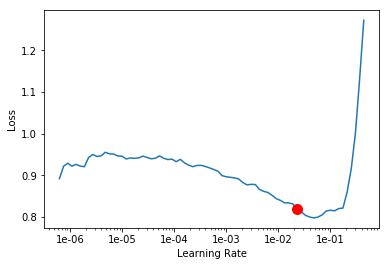

In [7]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,precision,recall,auroc,f_beta,f_beta,time
0,0.724527,0.478903,0.773302,0.833720,0.879584,0.766809,0.856038,0.870012,01:11
1,0.500639,0.439222,0.803747,0.818087,0.956601,0.830410,0.881939,0.925269,01:12
2,0.433873,0.411205,0.813583,0.829957,0.951711,0.842122,0.886674,0.924584,01:11
3,0.415047,0.389490,0.821077,0.842623,0.942543,0.852691,0.889786,0.920707,01:12
4,0.394662,0.376863,0.828103,0.851134,0.940098,0.865036,0.893407,0.920848,01:12
5,0.382030,0.365105,0.835129,0.862302,0.933985,0.873898,0.896714,0.918711,01:11
6,0.377200,0.362618,0.832318,0.863481,0.927873,0.875456,0.894520,0.914237,01:12
7,0.366625,0.355121,0.837471,0.859855,0.941320,0.882182,0.898745,0.923815,01:12
8,0.346368,0.353297,0.841218,0.863713,0.941320,0.883146,0.900848,0.924703,01:11
9,0.354432,0.353272,0.842155,0.863866,0.942543,0.883530,0.901491,0.925681,01:12


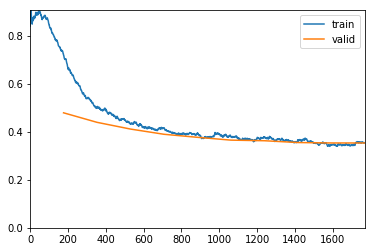

In [8]:
lr = 1e-3
learn.fit_one_cycle(10,slice(lr))
#learn.fit_one_cycle(1,1e-3)

In [9]:
learn.save(f"{exp_label}_pneumo_{half_resolution}_before_unfreeze")


In [10]:
learn.load(f"{exp_label}_pneumo_{half_resolution}_before_unfreeze");

In [11]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 3.98E-07


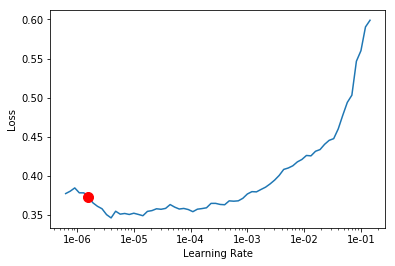

In [12]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,precision,recall,auroc,f_beta,f_beta,time
0,0.339780,0.349690,0.845902,0.871518,0.937042,0.885060,0.903093,0.923160,01:37
1,0.339411,0.332879,0.852927,0.876424,0.940709,0.898556,0.907429,0.927108,01:37
2,0.320450,0.329393,0.859485,0.883467,0.940709,0.902812,0.911190,0.928675,01:37
3,0.294028,0.318854,0.864169,0.889919,0.938875,0.905787,0.913742,0.928658,01:37
4,0.283581,0.314148,0.864637,0.889983,0.939487,0.912045,0.914065,0.929150,01:37
5,0.255276,0.307677,0.867447,0.894461,0.937653,0.914562,0.915548,0.928684,01:37
6,0.242918,0.307448,0.869321,0.899353,0.933985,0.916442,0.916342,0.926847,01:37
7,0.232642,0.304882,0.866042,0.907117,0.919315,0.918569,0.913175,0.916849,01:38
8,0.228501,0.305102,0.869321,0.903629,0.928484,0.917897,0.915888,0.923404,01:37
9,0.220779,0.307296,0.871194,0.896331,0.940709,0.918616,0.917984,0.931485,01:36


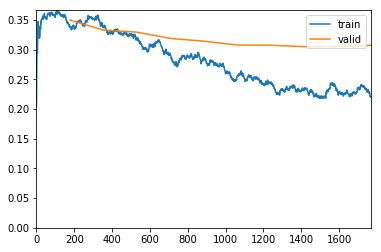

In [13]:
#learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-5))
lr = 1e-3
learn.fit_one_cycle(10, slice(1e-6,lr/5), wd=1e-7)
#learn.fit_one_cycle(1, lr, wd=1e-7)

In [14]:
learn.save(f"{exp_label}_pneumo_{half_resolution}_after_unfreeze")

In [15]:
learn.load(f"{exp_label}_pneumo_{half_resolution}_after_unfreeze");

In [16]:
# Starting with image size 768
data = (src.transform(tfms, size=full_resolution)
           .databunch(bs=8, path='.').normalize(imagenet_stats))

In [17]:
learn.data = data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 3.31E-07


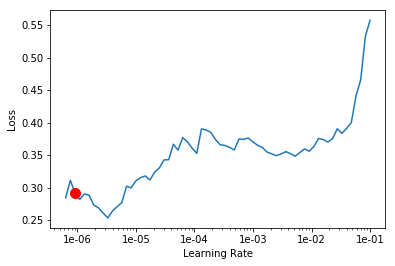

In [18]:
learn.freeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,precision,recall,auroc,f_beta,f_beta,time
0,0.355051,0.329934,0.857143,0.867883,0.959658,0.909985,0.911466,0.939782,03:02
1,0.357590,0.347352,0.846838,0.848695,0.973716,0.907055,0.906917,0.945850,03:02
2,0.330912,0.311867,0.855738,0.897605,0.916259,0.911624,0.906836,0.912467,03:02
3,0.306291,0.341350,0.859953,0.870360,0.960269,0.907339,0.913107,0.940831,03:02
4,0.277566,0.303494,0.870258,0.896210,0.939487,0.916551,0.917338,0.930500,03:01
5,0.256265,0.307815,0.867916,0.891329,0.942543,0.916665,0.916221,0.931835,03:02
6,0.270560,0.323093,0.862295,0.874442,0.957824,0.919647,0.914236,0.939899,03:03
7,0.269607,0.323770,0.863700,0.868493,0.968826,0.922689,0.915920,0.946947,03:02
8,0.309604,0.302939,0.869789,0.891580,0.944988,0.921646,0.917507,0.933800,03:02
9,0.300957,0.313265,0.869321,0.880112,0.960269,0.921441,0.918445,0.943090,03:12


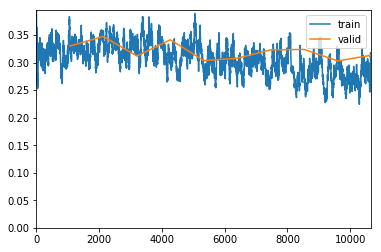

In [19]:
#learn.fit_one_cycle(10, 1e-6, wd=5e-6)
lr = 1e-3
learn.fit_one_cycle(10, slice(lr), wd=5e-6)
#learn.fit_one_cycle(1, slice(3e-3), wd=5e-6)

In [20]:
learn.save(f"{exp_label}_pneumo_{full_resolution}_before_unfreeze")


In [21]:
learn.unfreeze()
learn = learn.clip_grad();

epoch,train_loss,valid_loss,accuracy,precision,recall,auroc,f_beta,f_beta,time
0,0.303993,0.326408,0.873068,0.888889,0.953545,0.922449,0.920083,0.939872,04:53
1,0.321275,0.350964,0.866979,0.876812,0.961491,0.920927,0.917201,0.943272,04:54
2,0.367363,0.477691,0.848244,0.845263,0.981663,0.915033,0.908371,0.950971,04:52
3,0.318964,0.413307,0.861827,0.868609,0.965770,0.924614,0.914616,0.944637,04:53
4,0.284645,0.455422,0.861827,0.859903,0.979218,0.927835,0.915690,0.952777,04:54
5,0.321333,0.436699,0.877283,0.891230,0.956601,0.929212,0.922759,0.942771,04:56
6,0.252225,0.416773,0.884309,0.903544,0.950489,0.924695,0.926422,0.940714,04:53
7,0.210576,0.487077,0.879625,0.891095,0.960269,0.921184,0.924390,0.945588,04:55
8,0.212584,0.522770,0.878220,0.886083,0.965159,0.919911,0.923932,0.948234,04:55
9,0.306018,0.564266,0.876347,0.881535,0.968826,0.922670,0.923122,0.950012,04:46


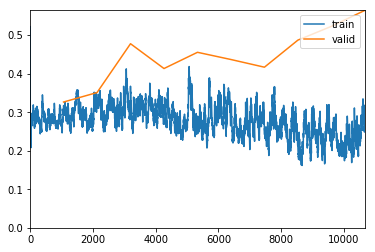

In [22]:
lr = 1e-3
learn.fit_one_cycle(10, slice(1e-6,lr/5))
#learn.fit_one_cycle(1, lr)
#learn.fit_one_cycle(5, slice(1e-6))

In [23]:
learn.save(f"{exp_label}_pneumo_{full_resolution}_after_unfreeze")

In [24]:
# BEST MODEL is loaded before running on test data
learn.load(f"{exp_label}_pneumo_{full_resolution}_after_unfreeze")

#learn.load(f"{exp_label}_pneumo_{half_resolution}_after_unfreeze");

Learner(data=ImageDataBunch;

Train: LabelList (8540 items)
x: ImageList
Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768)
y: CategoryList
no_disease,no_disease,no_disease,no_disease,no_disease
Path: classifier_data_768;

Valid: LabelList (2135 items)
x: ImageList
Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768)
y: CategoryList
no_disease,no_disease,no_disease,no_disease,no_disease
Path: classifier_data_768;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): B

In [25]:
sample_df = pd.read_csv('../sample_submission.csv')
sample_df.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6067.151787519...,-1
1,1.2.276.0.7230010.3.1.4.8323329.6214.151787519...,-1
2,1.2.276.0.7230010.3.1.4.8323329.6177.151787519...,-1
3,1.2.276.0.7230010.3.1.4.8323329.6655.151787519...,-1
4,1.2.276.0.7230010.3.1.4.8323329.6359.151787519...,-1


In [26]:
learn.data.add_test(ImageList.from_df(sample_df,f'../data{full_resolution}/',folder='test',suffix='.png'))

In [27]:
preds,_ = learn.get_preds(ds_type=DatasetType.Test)
cls_pred = F.softmax(preds,1).argmax(1).cpu().numpy()

In [28]:
paths = list(map(str,list(learn.data.test_ds.x.items)))
all_test_paths = [p.split('/')[-1][:-4] for p in paths]

df_preds = pd.DataFrame()
df_preds['test_paths'] = all_test_paths
df_preds['class_pred'] = cls_pred

df_preds.set_index('test_paths',inplace=True)

In [29]:
df_preds.head()

,class_pred
test_paths,
1.2.276.0.7230010.3.1.4.8323329.6067.1517875195.915618,1
1.2.276.0.7230010.3.1.4.8323329.6214.1517875197.83920,1
1.2.276.0.7230010.3.1.4.8323329.6177.1517875196.880733,0
1.2.276.0.7230010.3.1.4.8323329.6655.1517875199.413686,1
1.2.276.0.7230010.3.1.4.8323329.6359.1517875197.803699,1


In [30]:
no_dis_idx = df_preds[df_preds.class_pred==1].index
print(len(no_dis_idx))

1177


In [31]:
sub = pd.read_csv('new_aug.csv',index_col=['ImageId'])
sub.head(25)
sub.fillna(value=' -1',inplace=True)
sub.head()


,EncodedPixels
ImageId,
1.2.276.0.7230010.3.1.4.8323329.6067.1517875195.915618,-1
1.2.276.0.7230010.3.1.4.8323329.6214.1517875197.83920,-1
1.2.276.0.7230010.3.1.4.8323329.6177.1517875196.880733,562270 4 1019 6 1006 23 997 30 991 34 989 35 9...
1.2.276.0.7230010.3.1.4.8323329.6655.1517875199.413686,-1
1.2.276.0.7230010.3.1.4.8323329.6359.1517875197.803699,-1


In [32]:
sub.loc[no_dis_idx] = ' -1'


In [33]:
sub.to_csv(f'{exp_label}_{model_name}_{half_resolution}_{full_resolution}_classifier_correction_final_model.csv')

In [34]:
interp = ClassificationInterpretation.from_learner(learn)

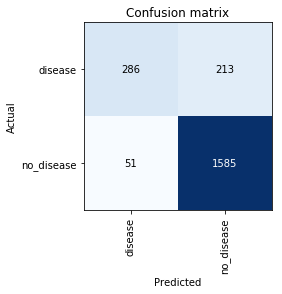

In [35]:
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(9, figsize=(14,14))

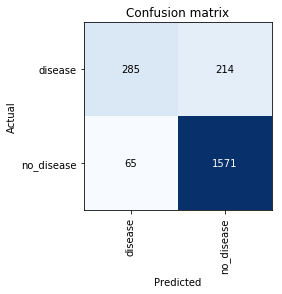

In [36]:
learn.load(f"{exp_label}_pneumo_{full_resolution}_before_unfreeze")
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
get_transforms